In [23]:
import torch.optim as optim
import torch
import numpy as np
import matplotlib.pyplot as plt

In [24]:
#read in the data, get normalized adjacency (NxN)
%run helpers_preproc.ipynb
mesh_dir = 'SHREC11/'

label_np = np.array(readLbl(mesh_dir+'labels.txt'))
label_mat_np = np.where(igl.all_pairs_distances(label_np,label_np,False) > 0.5,0,1)
label_mat = torch.tensor(label_mat_np,requires_grad=False)

In [25]:
normed_adjMats_list = []
node_sigs_list = []

for i in range(600):
    fName = 'T' + str(i) + '.obj'
    adj_noscale_read = obj_2_adj_noscale(mesh_dir + fName)
    adj_scaled_read = obj_2_adj(mesh_dir + fName)

    if (adj_scaled_read.shape[0] < 252):
        adj_noscale = np.empty([252,252])
        adj_scaled = np.empty([252,252])
    else:
        adj_noscale = adj_noscale_read
        adj_scaled = adj_scaled_read

    adj_normalized = adj_noscale / np.reshape(np.sum(adj_noscale,axis = 1),[adj_noscale.shape[0],1])

    node_degs = np.sum(adj_noscale,axis = 0)
    node_neigh_max = np.max(adj_scaled,axis = 0)
    node_neigh_min = np.min(adj_scaled,axis = 0)

    node_sig = np.stack([node_degs,node_neigh_max,node_neigh_min],axis = 1)
    node_sigs_list.append(node_sig)

    normed_adjMats_list.append(adj_normalized)

In [26]:
normed_adjMats = np.stack(normed_adjMats_list)
node_sigs = np.stack(node_sigs_list)

normed_adjMats = torch.tensor(normed_adjMats,requires_grad=False).float()
node_sigs = torch.tensor(node_sigs,requires_grad=False).float()

In [22]:
node_sigs.shape

(600, 252, 3)

In [52]:
class GCN(torch.nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.f = 1
        self.widths = widths
        self.weights = []
        self.weights.append(torch.autograd.Variable(torch.rand(size = [self.f,widths[0]])-0.5,requires_grad = True))

        for i in range(1,len(self.widths)):
            c = self.widths[i]
            self.weights.append(torch.autograd.Variable(torch.rand((self.widths[i-1],self.widths[i]))-0.5,requires_grad = True))

    def forward(self, adjM,node_sigM):
        curr_output = torch.tanh(torch.matmul(torch.matmul(adjM,node_sigM),self.weights[0])) #nxc
        for i in range(1,len(self.widths)):
            curr_output = torch.tanh(torch.matmul(torch.matmul(adjM,curr_output),self.weights[i])) #nxc

        return curr_output

torch.Size([600, 252, 4])

In [53]:
class NNN(torch.nn.Module):
    def __init__(self, widths):
        super().__init__()
        self.input_shape = 2520
        self.widths = widths
        self.weights = []
        self.weights.append(torch.autograd.Variable(torch.rand(size = [self.input_shape,widths[0]])-0.5,requires_grad = True))

        for i in range(1,len(self.widths)):
            c = self.widths[i]
            self.weights.append(torch.autograd.Variable(torch.rand((self.widths[i-1],self.widths[i]))-0.5,requires_grad = True))

    def forward(self, x):
        x = torch.flatten(x,1,2)
        torch.matmul(x,self.weights[0])
        curr_output = torch.tanh(torch.matmul(x,self.weights[0])) #nxc
        for i in range(1,len(self.widths)):
            curr_output = torch.tanh(torch.matmul(curr_output,self.weights[i])) #nxc

        return curr_output

torch.Size([600, 252, 252])

In [60]:
adj = torch.tensor(adjMats, requires_grad= False).float()
node_sig = torch.tensor(np.ones([600,252,1]),requires_grad= False).float()

check = torch.sum(torch.isnan(adj))
check

In [61]:
g = GCN([10])
n = NNN([10])
output1 = g.forward(adj,node_sig)
output2 = n.forward(output1)
print(output2)

In [151]:
def lossF(features):
    disMat = torch.cdist(features,features)
    sameType = disMat * label_mat
    diffType = disMat * (1-label_mat)
    sameTypeMean = torch.sum(sameType) / 12000
    diffTypeMean = torch.sum(diffType) /348000
    #print(disMat)
    return  sameTypeMean - diffTypeMean

tensor([[[-0.6241,  0.8086,  0.7913,  ..., -0.8110,  0.0251, -0.6939],
         [-0.6354,  0.8119,  0.7937,  ..., -0.8164,  0.0330, -0.6912],
         [-0.6256,  0.8101,  0.7916,  ..., -0.8144,  0.0291, -0.6950],
         ...,
         [-0.6076,  0.8064,  0.7854,  ..., -0.8119,  0.0297, -0.7015],
         [-0.6209,  0.8085,  0.7891,  ..., -0.8127,  0.0301, -0.6961],
         [-0.6134,  0.8078,  0.7876,  ..., -0.8135,  0.0305, -0.6996]],

        [[-0.6349,  0.8076,  0.7880,  ..., -0.8073,  0.0337, -0.6869],
         [-0.6051,  0.8005,  0.7818,  ..., -0.7977,  0.0205, -0.6958],
         [-0.5965,  0.7991,  0.7791,  ..., -0.7976,  0.0225, -0.6988],
         ...,
         [-0.6019,  0.8012,  0.7810,  ..., -0.8009,  0.0243, -0.6983],
         [-0.6138,  0.8061,  0.7829,  ..., -0.8110,  0.0380, -0.6976],
         [-0.5990,  0.7999,  0.7806,  ..., -0.7985,  0.0212, -0.6984]],

        [[-0.6218,  0.8041,  0.7853,  ..., -0.8021,  0.0263, -0.6908],
         [-0.6138,  0.8028,  0.7829,  ..., -0

In [157]:
optimizer = optim.Adam(g.weights + n.weights,lr = 0.0001)

for i in range(10000):
    optimizer.zero_grad()
    output = n.forward(g.forward(adj,node_sig))
    loss = lossF(output)
    loss.backward()
    optimizer.step()
    print(loss)

In [176]:
disMat = torch.cdist(output,output)
sameType = disMat * label_mat
diffType = disMat * (1-label_mat)
sameTypeMean = torch.sum(sameType) / 12000
diffTypeMean = torch.sum(diffType) /348000

tensor(-1.2732, grad_fn=<AddBackward0>)
tensor(-0.5330, grad_fn=<AddBackward0>)
tensor(-1.2555, grad_fn=<AddBackward0>)
tensor(-1.0216, grad_fn=<AddBackward0>)
tensor(-1.1377, grad_fn=<AddBackward0>)
tensor(-1.2617, grad_fn=<AddBackward0>)
tensor(-1.2522, grad_fn=<AddBackward0>)
tensor(-1.1503, grad_fn=<AddBackward0>)
tensor(-1.1885, grad_fn=<AddBackward0>)
tensor(-1.2576, grad_fn=<AddBackward0>)
tensor(-1.2641, grad_fn=<AddBackward0>)
tensor(-1.2420, grad_fn=<AddBackward0>)
tensor(-1.2084, grad_fn=<AddBackward0>)
tensor(-1.2109, grad_fn=<AddBackward0>)
tensor(-1.2427, grad_fn=<AddBackward0>)
tensor(-1.2643, grad_fn=<AddBackward0>)
tensor(-1.2690, grad_fn=<AddBackward0>)
tensor(-1.2603, grad_fn=<AddBackward0>)
tensor(-1.2446, grad_fn=<AddBackward0>)
tensor(-1.2442, grad_fn=<AddBackward0>)
tensor(-1.2593, grad_fn=<AddBackward0>)
tensor(-1.2692, grad_fn=<AddBackward0>)
tensor(-1.2711, grad_fn=<AddBackward0>)
tensor(-1.2668, grad_fn=<AddBackward0>)
tensor(-1.2589, grad_fn=<AddBackward0>)


KeyboardInterrupt: 

In [177]:
sameTypeMean

In [178]:
diffTypeMean

0.11228981614112854 0.8249748349189758


In [179]:
output

1.5212464332580566 1.398271083831787


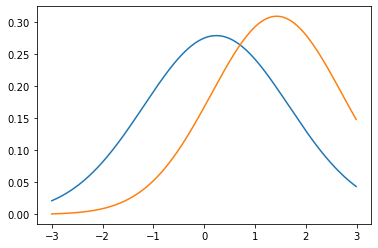

In [174]:
g.forward(adj,node_sig)

In [ ]:
mat = np.empty([30,30])
plt.matshow(mat)
self_mean = np.mean(compSelf)
self_std = np.std(compSelf)
others_mean = np.mean(compOthers)
others_std = np.std(compOthers)

In [200]:


c1 = 10
c2 = 20
c3 = 30

weights_1 = torch.rand(size = [1,c1], requires_grad= True)
weights_2 = torch.rand([c1,c2],requires_grad= True)
weights_3 = torch.rand([c2,c3], requires_grad= False)

In [201]:
def GCN(adjM,node_sigM):
    layer_1_output = torch.matmul(torch.matmul(adjM,node_sigM),weights_1) #nxc
    #layer 2
    layer_2_output = torch.matmul(torch.matmul(adj,layer_1_output),weights_2) #nxc
    #layer 2
    layer_3_output = torch.matmul(torch.matmul(adj,layer_2_output),weights_3) #nxc
    return layer_3_output

In [202]:

optimizer = optim.Adam([weights_1,weights_2,weights_3],lr = 0.01)

for i in range(100):
    optimizer.zero_grad()
    output = GCN(adj,node_sig)
    #output = torch.mean(weights_1)
    loss = torch.mean(output)
    loss.backward()
    optimizer.step()
    print(loss)

tensor(439.9774, grad_fn=<MeanBackward0>)
tensor(421.3802, grad_fn=<MeanBackward0>)
tensor(403.1801, grad_fn=<MeanBackward0>)
tensor(385.3835, grad_fn=<MeanBackward0>)
tensor(367.9957, grad_fn=<MeanBackward0>)
tensor(351.0208, grad_fn=<MeanBackward0>)
tensor(334.4612, grad_fn=<MeanBackward0>)
tensor(318.3172, grad_fn=<MeanBackward0>)
tensor(302.5864, grad_fn=<MeanBackward0>)
tensor(287.2630, grad_fn=<MeanBackward0>)
tensor(272.3385, grad_fn=<MeanBackward0>)
tensor(257.8025, grad_fn=<MeanBackward0>)
tensor(243.6440, grad_fn=<MeanBackward0>)
tensor(229.8531, grad_fn=<MeanBackward0>)
tensor(216.4211, grad_fn=<MeanBackward0>)
tensor(203.3407, grad_fn=<MeanBackward0>)
tensor(190.6051, grad_fn=<MeanBackward0>)
tensor(178.2077, grad_fn=<MeanBackward0>)
tensor(166.1418, grad_fn=<MeanBackward0>)
tensor(154.4001, grad_fn=<MeanBackward0>)
tensor(142.9748, grad_fn=<MeanBackward0>)
tensor(131.8571, grad_fn=<MeanBackward0>)
tensor(121.0378, grad_fn=<MeanBackward0>)
tensor(110.5065, grad_fn=<MeanBack

In [249]:
a = torch.tensor([450,500,300])
torch.tanh(a)

tensor([1., 1., 1.])

In [203]:
# adj_tensor = torch.tensor(adjMats)
# edge_indx = adj_tensor.nonzero().t().contiguous()

In [207]:
# # print(edge_indx)
# # print(edge_indx.shape)
# print(torch.max(edge_indx))
# print(edge_indx.size())

In [201]:
# data = torch_geometric.data.Data(x = torch.zeros(252,1), edge_index=edge_indx)

In [202]:
# #hyper parameters
# in_channels = 252
# out_channels = 10

In [203]:
# #set up gnn
# model = Sequential('x, edge_index', [
#     (GCNConv(in_channels, 64), 'x, edge_index -> x'),
#     ReLU(inplace=True),
#     (GCNConv(64, 64), 'x, edge_index -> x'),
#     ReLU(inplace=True),
#     Linear(64, out_channels),
# ])

In [208]:
# data = torch.tensor(adjMats).float()
#
# model(data,edge_indx)


In [ ]:
#run gnn, get (NxC) matrix


In [ ]:
#compute contrastive loss


In [ ]:
#update weights (FxC)
